In [1]:
!pip install gluonts
!pip install mxnet

     |████████████████████████████████| 901kB 5.4MB/s 
     |████████████████████████████████| 10.1MB 11.6MB/s 
     |████████████████████████████████| 46.9MB 69kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
#Eseguire se si vuole usare la GPU

isGPU = False

if isGPU:
  !pip uninstall mxnet
  !pip install -U --pre mxnet-cu80
 
  !pip install mxnet-cu80==0.11.0
  !pip install mxnet-cu100

In [3]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [4]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/m5-uncertainty.zip'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/m5-uncertainty.zip
   creating: m5-uncertainty/
  inflating: m5-uncertainty/calendar.csv  
  inflating: m5-uncertainty/sales_train_evaluation.csv  
  inflating: m5-uncertainty/sales_train_validation.csv  
  inflating: m5-uncertainty/sample_submission.csv  
  inflating: m5-uncertainty/sell_prices.csv  


In [5]:
INPUT_DIR = '/content/m5-uncertainty'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
sell_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ste = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [6]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2

submission=True

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

In [7]:
cal.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


##Feature extraction and data preparation
First we extract features from the calendar, these are dynamic features

In [10]:
cal_features = cal.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

#So, rows become an attribute and columns becomes the evolution through days
test_cal_features = cal_features.values.T
if submission:
    train_cal_features = test_cal_features[:,:-submission_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-submission_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-submission_prediction_length]

#These two objects are two lists whose length is 30490
#The i-th element has shape (5,1969) for the test and (5,1913) for the train
#Where 5 is the number of calendar dynamic features
test_cal_features_list_orig = [test_cal_features] * len(stv)
train_cal_features_list_orig = [train_cal_features] * len(stv)

Now we deal with static feature provided together with the series

In [11]:
#Explanation of what is done: for each attribute we are interested in it casts
#the column to the type category and then it extracts the np.array of the 
#codes to which 1 is summed in order to avoid to start from code 0.
#At this point it has an array of 30490 elements that makes unique and count
#how many times they are repeated.
#Finally it creates a dictionary where the key is the original values in the table
#and the value corresponding to the key is the code

state_ids = stv["state_id"].astype('category').cat.codes.values + 1
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)
state_ids_dict = dict(zip(stv["state_id"], stv["state_id"].astype('category').cat.codes + 1))

store_ids = stv["store_id"].astype('category').cat.codes.values + 1
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)
store_ids_dict = dict(zip(stv["store_id"], stv["store_id"].astype('category').cat.codes + 1))

cat_ids = stv["cat_id"].astype('category').cat.codes.values + 1
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)
cat_ids_dict = dict(zip(stv["cat_id"], stv["cat_id"].astype('category').cat.codes + 1))

dept_ids = stv["dept_id"].astype('category').cat.codes.values + 1
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)
dept_ids_dict = dict(zip(stv["dept_id"], stv["dept_id"].astype('category').cat.codes + 1))

item_ids = stv["item_id"].astype('category').cat.codes.values + 1
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)
item_ids_dict = dict(zip(stv["item_id"], stv["item_id"].astype('category').cat.codes + 1))

#This is a list of 5 elements where each element stores 30490 values
#that are the static features of an annitrubute of 5
stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

#First attach all the list one after the other and then reshape
stat_cat_orig = np.concatenate(stat_cat_list)
stat_cat_orig = stat_cat_orig.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un) + 1, len(dept_ids_un) + 1, len(cat_ids_un) + 1, len(store_ids_un) + 1, len(state_ids_un) + 1]

In [8]:
DIR = '/content/drive/MyDrive'
agg_series = np.load(f'{DIR}/aggregates.npy') 
agg_cat = np.load(f'{DIR}/aggregates_cat.npy')
agg_series_eval = np.load(f'{DIR}/aggregates_evaluation.npy')

In [ ]:
import itertools

states = ["CA", "TX", "WI"]
states_alt = ["WI", "CA", "TX"]
stores = ["CA_1", "CA_2", "CA_3", "CA_4", "TX_1", "TX_2", "TX_3", "WI_1", "WI_2", "WI_3"]
categories = ["FOODS", "HOBBIES", "HOUSEHOLD"]
departments = ["FOODS_1", "FOODS_2", "FOODS_3", "HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_1", "HOUSEHOLD_2"]
departments_counts = {
    "FOODS_1": 219,
    "FOODS_2": 399,
    "FOODS_3": 827,
    "HOBBIES_1": 424,
    "HOBBIES_2": 149,
    "HOUSEHOLD_1": 541,
    "HOUSEHOLD_2": 516
}

def select_series(identifier="", item_id="", dept_id="", cat_id="", store_id="", state_id=""):
    return stv[(stv['id'].str.contains(identifier)) &
                                  (stv['item_id'].str.contains(item_id)) &
                                  (stv['dept_id'].str.contains(dept_id)) &
                                  (stv['cat_id'].str.contains(cat_id)) &
                                  (stv['store_id'].str.contains(store_id)) &
                                  (stv['state_id'].str.contains(state_id))]

#Initialize two np.array of the shape between parenthesis
agg_series = np.empty((0,1913), int)
agg_cat = np.empty((0,5), int)

#Here we are aggregating all the time series so to the initialized empty array
#we append the result of the sum by column of all the series in all the 1913 days
agg_series = np.append(agg_series, [select_series().iloc[:,6:].values.sum(axis=0)], axis=0)
#Here we sat the categorical static attributes for the highest level of aggregation
agg_cat = np.append(agg_cat, [[0,0,0,0,0]], axis=0)

#Fore every state we select all the series that belongs to that state, we sum all
#the values by column obtaining just one line for each state and we append these 3 lines
#since 3 are the states to the previous agg_series. We also append the categorical
#attributes for the 3 series
for state in tqdm(states):
    agg_series = np.append(agg_series, [select_series(identifier=state).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,0,0,state_ids_dict[state]]], axis=0)
    
for store in tqdm(stores):
    agg_series = np.append(agg_series, [select_series(identifier=store).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,0,store_ids_dict[store],0]], axis=0)

for category in tqdm(categories):
    agg_series = np.append(agg_series, [select_series(identifier=category).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[category],0,0]], axis=0)

for department in tqdm(departments):
    agg_series = np.append(agg_series, [select_series(identifier=department).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[department],0,0,0]], axis=0)
    
    
states_categories = list(itertools.product(states,categories))
for sc in tqdm(states_categories):
    agg_series = np.append(agg_series, [select_series(state_id=sc[0], cat_id=sc[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[sc[1]],0,state_ids_dict[sc[0]]]], axis=0)
    
states_departments = list(itertools.product(states,departments))
for sd in tqdm(states_departments):
    agg_series = np.append(agg_series, [select_series(state_id=sd[0], dept_id=sd[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[sd[1]],0,0,state_ids_dict[sd[0]]]], axis=0)
    
stores_categories = list(itertools.product(stores,categories))
for sc in tqdm(stores_categories):
    agg_series = np.append(agg_series, [select_series(store_id=sc[0], cat_id=sc[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,0,cat_ids_dict[sc[1]],store_ids_dict[sc[0]],0]], axis=0)
    
stores_departments = list(itertools.product(stores,departments))
for sd in tqdm(stores_departments):
    agg_series = np.append(agg_series, [select_series(store_id=sd[0], dept_id=sd[1]).iloc[:,6:].values.sum(axis=0)], axis=0)
    agg_cat = np.append(agg_cat, [[0,dept_ids_dict[sd[1]],0,store_ids_dict[sd[0]],0]], axis=0)
    
for department in tqdm(departments):
    for t_id in tqdm(range(1, departments_counts[department] + 1)):
        ident_str = f'{department}_{t_id:03}'
        series = select_series(item_id=ident_str).iloc[:,6:].values.sum(axis=0)
        if np.sum(series) > 0:
            agg_series = np.append(agg_series, [series], axis=0)
            agg_cat = np.append(agg_cat, [[item_ids_dict[ident_str],dept_ids_dict[department],0,0,0]], axis=0)
            
for state in tqdm(states_alt):
    for department in tqdm(departments):
        for t_id in tqdm(range(1, departments_counts[department] + 1)):
            ident_str = f'{department}_{t_id:03}'
            series = select_series(item_id=ident_str, state_id=state).iloc[:,6:].values.sum(axis=0)
            if np.sum(series) > 0:
                agg_series = np.append(agg_series, [series], axis=0)
                agg_cat = np.append(agg_cat, [[item_ids_dict[ident_str],dept_ids_dict[department],0,0,state_ids_dict[state]]], axis=0)
                
np.save(f'{INPUT_DIR}/aggregates.npy', agg_series) 
np.save(f'{INPUT_DIR}/aggregates_cat.npy', agg_cat)

NameError: ignored

Now we create also the dynamic categorical features also for the aggregation levels

In [12]:
#test_cal_features has shape (5,1969), in the following line it is multiplied
#by the number of all the aggregate time series so in this way we can have
#the 5 categorical dynamic attributes for each time step
test_cal_features_list = [test_cal_features] * len(agg_series)
#Explaining next row: before test_cal_features_list has (5,1969) for len(agg_series),
#after the following row this will be expanded adding (5,1969) elements also
#for every series in stv
test_cal_features_list.extend(test_cal_features_list_orig)
train_cal_features_list = [train_cal_features] * len(agg_series)
train_cal_features_list.extend(train_cal_features_list_orig)

#We do the same for categorical static attributes
stat_cat = np.append(agg_cat, stat_cat_orig, axis=0)

#Finally we define the target
train_df = stv.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
eval_df = ste.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
series_tot = np.append(agg_series, train_df.values, axis=0)
series_tot_eval = np.append(agg_series_eval, eval_df, axis=0)

In [44]:
print(series_tot.shape, series_tot_eval.shape)

(42840, 1913) (42840, 1941)


Now we prepare the training and test set according to the format accepted by gluonts

In [58]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

#first 1913 has known values while last 56 nan
if submission == True:
    train_target_values = [ts for ts in series_tot]
    eval_target_values = [ts for ts in series_tot_eval]
    test_target_values = [np.append(ts, np.ones(submission_prediction_length) * np.nan) for ts in series_tot]
else:
    test_target_values = series_tot.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in series_tot]
    
m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(train_target_values))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

eval_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
    }
    for (target, start) in zip(eval_target_values,
                                         m5_dates)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

In [59]:
next(iter(train_ds))

{'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([0, 0, 0, 0, 0], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([32631., 31749., 23783., ..., 40517., 48962., 49795.], dtype=float32)}

In [61]:
next(iter(eval_ds))

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([32631., 31749., 23783., ..., 42552., 51518., 54338.], dtype=float32)}

In [60]:
next(iter(test_ds))

{'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([0, 0, 0, 0, 0], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([32631., 31749., 23783., ...,    nan,    nan,    nan], dtype=float32)}

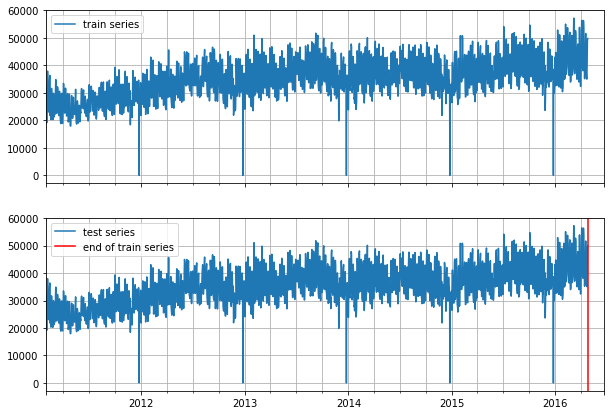

In [48]:
from gluonts.dataset.util import to_pandas

train_entry = next(iter(train_ds))
train_entry.keys()
test_entry = next(iter(test_ds))
test_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import NegativeBinomialOutput

estimator = DeepAREstimator(freq='D',
                            prediction_length=prediction_length,
                            num_layers=5, num_cells=40,                
                            trainer=Trainer(learning_rate=1e-3,
                                            ctx='gpu',
                                            epochs=400,  #provare 100 epoche 
                                            num_batches_per_epoch=100, #provare 200
                                            batch_size=64, # provare 100
                                            patience=20),
                            use_feat_static_cat=True, use_feat_dynamic_real=True,
                            cardinality=stat_cat_cardinalities, 
                            lags_seq=[1,2,3,4,5,6,7,14,28,365],
                            distr_output=NegativeBinomialOutput()
                            )
predictor = estimator.train(training_data=train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:19<00:00,  5.26it/s, epoch=162/400, avg_epoch_loss=2.16]


##Execute the next cell if you want to save the model

In [ ]:
from fastai import data_block

#I'm just trying to save the model but in case of real use 
#pleas check the path is the expected one
!mkdir ./drive/MyDrive/savedModel
path = data_block.Path('./drive/MyDrive/savedModel')

from pathlib import Path
predictor.serialize(path)

In [ ]:
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [13]:
import pickle

quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

#with open("forecast.txt", "wb") as fp:   #Pickling
 # pickle.dump(forecasts, fp)

#with open("tss.txt", "wb") as fp:   #Pickling
  #pickle.dump(tss, fp)
 
with open("drive/MyDrive/forecast.txt", "rb") as fp:   # Unpickling
  forecasts = pickle.load(fp)

with open("drive/MyDrive/tss.txt", "rb") as fp:   # Unpickling
  tss = pickle.load(fp)

In [ ]:
from google.colab import files
files.download('forecast.txt') 
files.download('tss.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Local submission validation
In the case sub mission == False

In [ ]:
#if submission == False:
    
#    from gluonts.evaluation import Evaluator
    
#    evaluator = Evaluator(quantiles=quantiles)
#    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
#    print(json.dumps(agg_metrics, indent=4))

from gluonts.evaluation import Evaluator
    
evaluator = Evaluator(quantiles=quantiles)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 42840/42840 [00:00<00:00, 224212.33it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


{
    "MSE": NaN,
    "abs_error": 0.0,
    "abs_target_sum": 0.0,
    "abs_target_mean": NaN,
    "seasonal_error": 2.456416646156392,
    "MASE": NaN,
    "MAPE": NaN,
    "sMAPE": NaN,
    "OWA": NaN,
    "MSIS": NaN,
    "QuantileLoss[0.005]": 0.0,
    "Coverage[0.005]": NaN,
    "QuantileLoss[0.025]": 0.0,
    "Coverage[0.025]": NaN,
    "QuantileLoss[0.165]": 0.0,
    "Coverage[0.165]": NaN,
    "QuantileLoss[0.25]": 0.0,
    "Coverage[0.25]": NaN,
    "QuantileLoss[0.5]": 0.0,
    "Coverage[0.5]": NaN,
    "QuantileLoss[0.75]": 0.0,
    "Coverage[0.75]": NaN,
    "QuantileLoss[0.835]": 0.0,
    "Coverage[0.835]": NaN,
    "QuantileLoss[0.975]": 0.0,
    "Coverage[0.975]": NaN,
    "QuantileLoss[0.995]": 0.0,
    "Coverage[0.995]": NaN,
    "RMSE": NaN,
    "NRMSE": NaN,
    "ND": NaN,
    "wQuantileLoss[0.005]": NaN,
    "wQuantileLoss[0.025]": NaN,
    "wQuantileLoss[0.165]": NaN,
    "wQuantileLoss[0.25]": NaN,
    "wQuantileLoss[0.5]": NaN,
    "wQuantileLoss[0.75]": NaN,
   

/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:439: RuntimeWarning: invalid value encountered in double_scalars
  totals["ND"] = totals["abs_error"] / totals["abs_target_sum"]
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:443: RuntimeWarning: invalid value encountered in double_scalars
  totals[quantile.loss_name] / totals["abs_target_sum"]


#Preparing the submission

In [17]:
if submission == True:
    def quantile_calc(q):
        res = np.ones((len(forecasts), prediction_length))
        for i, f in enumerate(forecasts):
            res[i] = f.quantile(q)
        return res

    allresults = list(map(quantile_calc, quantiles))
    allresults_conc = np.concatenate(allresults, axis=0)

In [18]:
if submission == True:
    forecasts_acc_sub = np.zeros((len(allresults_conc)*2, single_prediction_length))
    forecasts_acc_sub[:len(allresults_conc)] = allresults_conc[:,:single_prediction_length]
    forecasts_acc_sub[len(allresults_conc):] = allresults_conc[:,single_prediction_length:]

In [19]:
if submission == True:
    import time

    sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
    sample_submission.iloc[:,1:] = forecasts_acc_sub

    submission_id = 'submission_{}.csv'.format(int(time.time()))

    sample_submission.to_csv(submission_id, index=False)

In [ ]:
from google.colab import files
files.download('submission.csv') 

##Plots
We randomly select one example for each level of aggregation

In [56]:
examples = [0]

examples.append(np.random.randint(1,4))
examples.append(np.random.randint(4,14))
examples.append(np.random.randint(14,17))
examples.append(np.random.randint(17,24))
examples.append(np.random.randint(24,33))
examples.append(np.random.randint(33,54))
examples.append(np.random.randint(54,84))
examples.append(np.random.randint(84,154))
examples.append(np.random.randint(154,3203))
examples.append(np.random.randint(3203,12350))
examples.append(np.random.randint(12350,42840))
examples

levels = {1 : 'Unit sales of all products, aggregated for all stores/states', 
          2 : 'Unit sales of all products, aggregated for each State', 
          3 : 'Unit sales of all products, aggregated for each store', 
          4 : 'Unit sales of all products, aggregated for each category', 
          5 : 'Unit sales of all products, aggregated for each department', 
          6 : 'Unit sales of all products, aggregated for each State and category',
          7 : 'Unit sales of all products, aggregated for each State and department', 
          8 : 'Unit sales of all products, aggregated for each store and category', 
          9 : 'Unit sales of all products, aggregated for each store and department', 
          10 : 'Unit sales of product x, aggregated for all stores/states',
          11 : 'Unit sales of product x, aggregated for each State', 
          12 : 'Unit sales of product x, aggregated for each store'}

Plotting time series predictions ...
Level of aggregation: 1
Unit sales of all products, aggregated for all stores/states


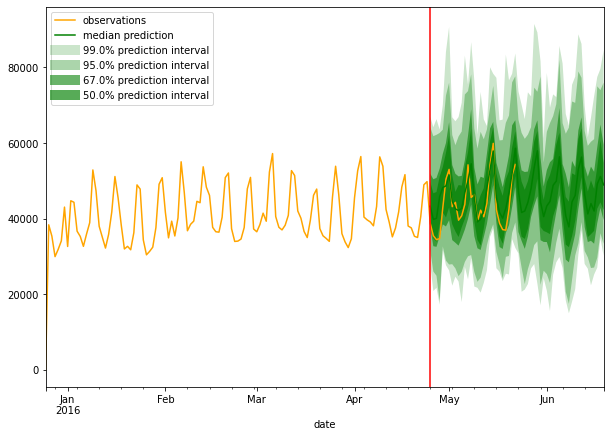

Level of aggregation: 2
Unit sales of all products, aggregated for each State


<Figure size 432x288 with 0 Axes>

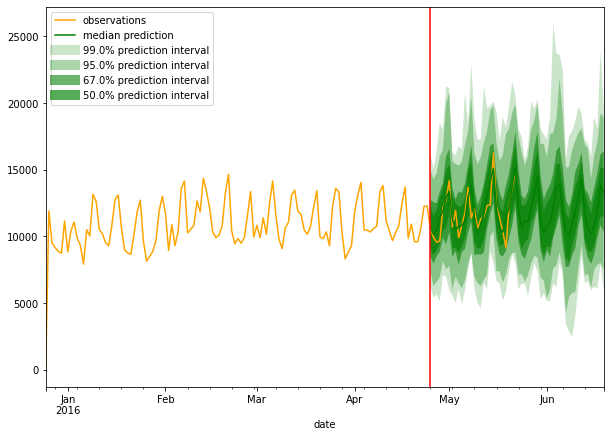

Level of aggregation: 3
Unit sales of all products, aggregated for each store


<Figure size 432x288 with 0 Axes>

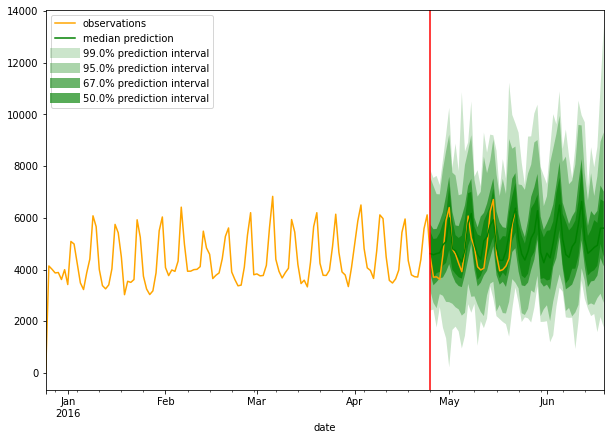

Level of aggregation: 4
Unit sales of all products, aggregated for each category


<Figure size 432x288 with 0 Axes>

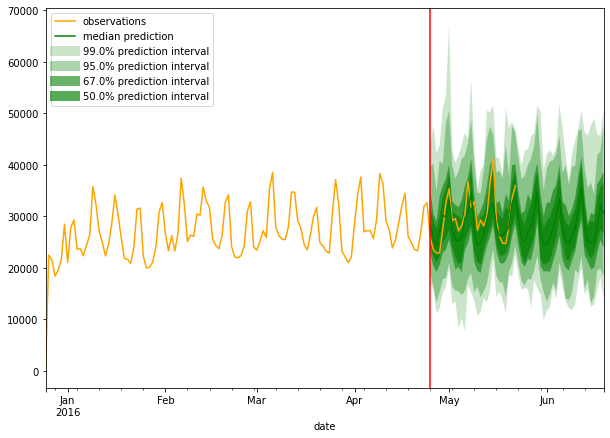

Level of aggregation: 5
Unit sales of all products, aggregated for each department


<Figure size 432x288 with 0 Axes>

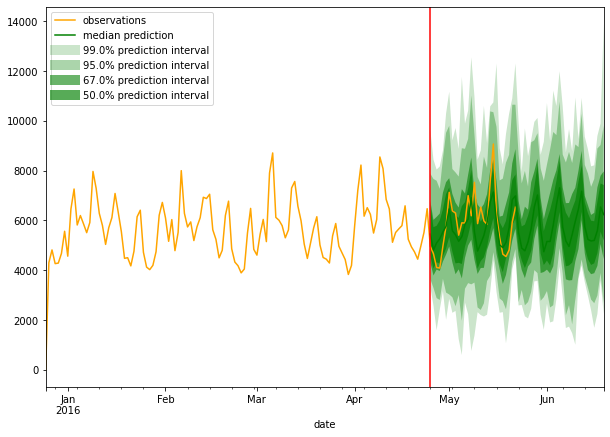

Level of aggregation: 6
Unit sales of all products, aggregated for each State and category


<Figure size 432x288 with 0 Axes>

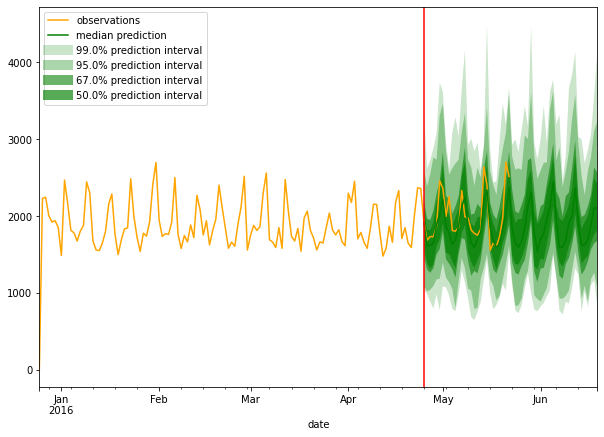

Level of aggregation: 7
Unit sales of all products, aggregated for each State and department


<Figure size 432x288 with 0 Axes>

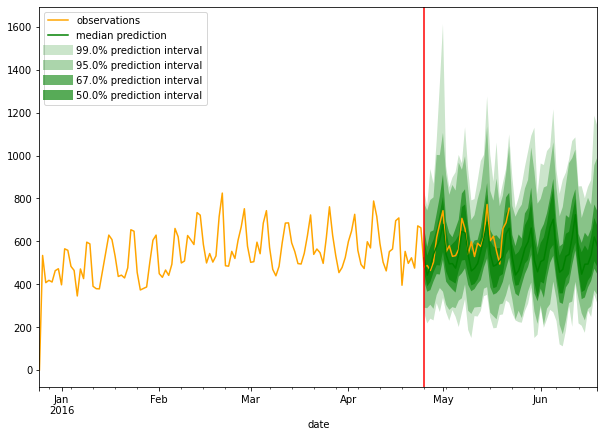

Level of aggregation: 8
Unit sales of all products, aggregated for each store and category


<Figure size 432x288 with 0 Axes>

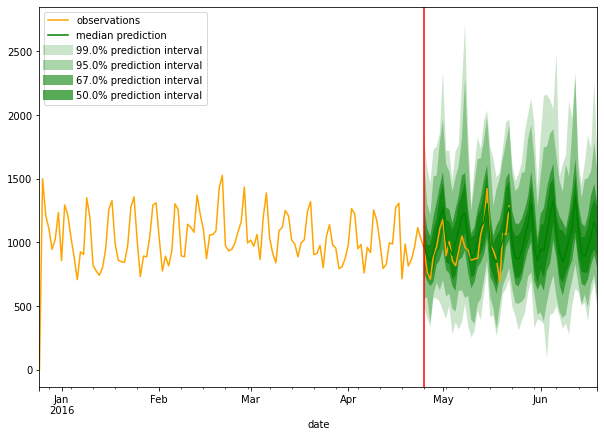

Level of aggregation: 9
Unit sales of all products, aggregated for each store and department


<Figure size 432x288 with 0 Axes>

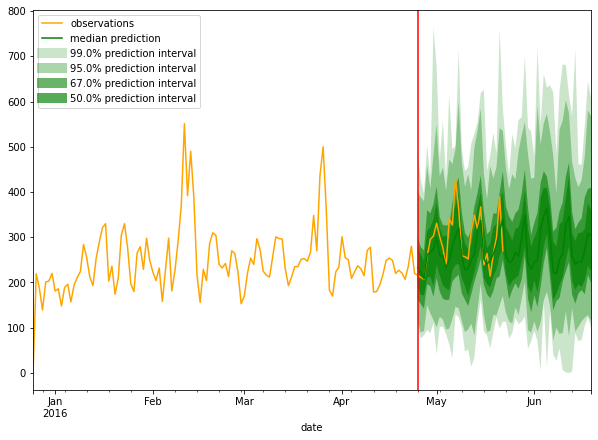

Level of aggregation: 10
Unit sales of product x, aggregated for all stores/states


<Figure size 432x288 with 0 Axes>

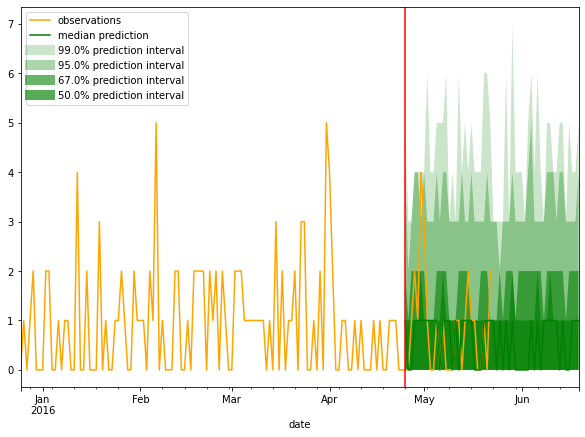

Level of aggregation: 11
Unit sales of product x, aggregated for each State


<Figure size 432x288 with 0 Axes>

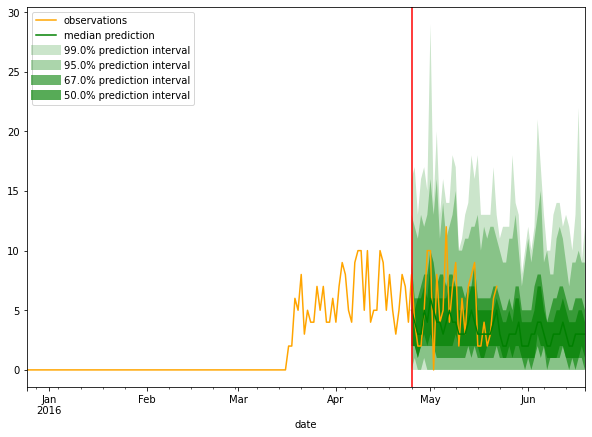

Level of aggregation: 12
Unit sales of product x, aggregated for each store


<Figure size 432x288 with 0 Axes>

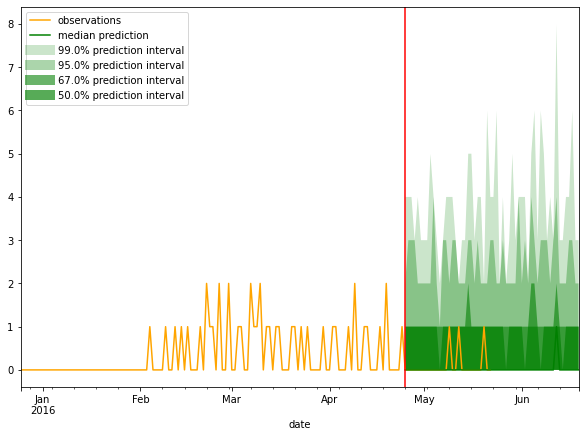

<Figure size 432x288 with 0 Axes>

In [57]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, level, inline=True):
    plot_length = 150
    prediction_intervals = (50.0, 67.0, 95.0, 99.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    print('Level of aggregation: ' + str(level + 1))
    print(levels[level+1])
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax, color='orange')
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-single_prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
dates = pd.date_range(start='2011-01-29 00:00:00', end='2016-05-22 00:00:00', freq='D')
for n, i in enumerate(examples):
    ts_entry = pd.DataFrame(series_tot_eval[i])
    ts_entry['date'] = dates
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry.set_index('date'), forecast_entry, plot_log_path, i, n)